## Pipeline for Binary Label Classification

#### Life cycle of Machine learning Project

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Exploratory data analysis
- Data Pre-Processing
- Model Training
- Choose best model

### 1) Problem statement
- This project seeks to understand how several features/variables affects loan repayability by customers seeking loans with a microfinance institution
- The factors include account_type, credit_duration(month), payment_status_of_previous_loan, loan_purpose, credit_amount, savings_type, duration_of_current_employment, installment_percent, marital_status, guarantor, duration_in_current_address, most_valuable_asset, age, concurrent_credits, type_of_apartment, no_of_credits_at_the_bank, occupation, telephone, foreign_work

- Note: "1" label was represented as bad and "0" was represented as good in the problem statement. This will be interchange appropriately in the label column for easy model training and assessment.

### 2) Data Collection
- Dataset Source - https://drive.google.com/file/d/1po5SW_7Vy8H9hRyIWSgAXcbPo0Ycss9J/view
- The data consists of 22 columns and 1000 rows.

### 2.1 Import Data and Required Packages

#### 2.1.1 Importing libraries

In [45]:
# Basic Import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# from lab_utils_common import dlc
# from lab_neurons_utils import plt_prob_1d, sigmoidnp, plt_linear, plt_logistic
# plt.style.use('./deeplearning.mplstyle')
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
import warnings
warnings.filterwarnings("ignore")

Upload files into Colab Environment

In [4]:
from google.colab import files

# Use the files.upload() method to upload a file
uploaded = files.upload()

# After running the above code, a file upload dialog will appear.
# Select the CSV file you want to upload from your local machine.

Saving classification.csv to classification.csv


#### 2.1.2 Import CSV data as dataframe

In [46]:
df = pd.read_csv('classification.csv')

In [47]:
df.head(2)

,user_id,label,Account type,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Savings type,Length of current employment,Instalment per cent,...,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,586266,1,1,18,4,2,1049,1,2,4,...,4,2,21,3,1,1,3,1,1,1
1,392565,1,1,9,4,0,2799,1,3,2,...,2,1,36,3,1,2,3,2,1,1


#### Create copy of dataset

In [48]:
dff = df.copy()

#### Reorganize label column

In [49]:
dff.groupby('label')['label'].count()

label
0    300
1    700
Name: label, dtype: int64

In [50]:
def interchange_label(x):
    final_label=''
    if x == 0:
        final_label=1
    else:
        final_label=0

    return final_label

dff['label'] = dff['label'].apply(interchange_label)

dff.groupby('label')['label'].count()

label
0    700
1    300
Name: label, dtype: int64

##### Insights

- Label "0" now represents bad and has 700 records after transformation.

#### 2.1.3 Renaming columns

#### account_type, credit_duration(month), payment_status_of_previous_loan, loan_purpose, credit_amount, savings_type, duration_of_current_employment, installment_percent, marital_status, guarantor, duration_in_current_address, most_valuable_asset, age, concurrent_credits, type_of_apartment, no_of_credits_at_the_bank, occupation, telephone, foreign_work

In [51]:
rename_dict = {'Account type': 'account_type','Duration of Credit (month)': 'credit_duration(month)',
               'Payment Status of Previous Credit':'payment_status_of_previous_loan','Purpose':'loan_purpose',
               'Credit Amount':'credit_amount','Savings type':'savings_type',
               'Length of current employment':'duration_of_current_employment',
               'Instalment per cent':'installment_percent','Marital Status':'marital_status',
               'Guarantors':'guarantors','Duration in Current address':'duration_in_current_address',
               'Most valuable available asset':'most_valuable_asset','Age':'age',
               'Concurrent Credits':'concurrent_credits','Type of apartment':'type_of_apartment',
               'No of Credits at this Bank':'no_of_credits_at_the_bank','Occupation':'occupation',
               'No of dependents':'no_of_dependents','Telephone':'telephone','Foreign Worker':'foreign_worker'}
dff = dff.rename(columns=rename_dict)


#### 2.1.4 preview data

In [52]:
dff.head(3)

,user_id,label,account_type,credit_duration(month),payment_status_of_previous_loan,loan_purpose,credit_amount,savings_type,duration_of_current_employment,installment_percent,...,duration_in_current_address,most_valuable_asset,age,concurrent_credits,type_of_apartment,no_of_credits_at_the_bank,occupation,no_of_dependents,telephone,foreign_worker
0,586266,0,1,18,4,2,1049,1,2,4,...,4,2,21,3,1,1,3,1,1,1
1,392565,0,1,9,4,0,2799,1,3,2,...,2,1,36,3,1,2,3,2,1,1
2,204665,0,2,12,2,9,841,2,4,2,...,4,1,23,3,1,1,2,1,1,1


#### Shape of dataset

In [ ]:
dff.shape

(1000, 22)

### 2.2 Dataset information

- user_id : unique ID identifying each customer (primary key)
- label: information on loan repayability after loan cycle ===> nominal variable (target variable)
- account_type: type of customers' account ===> nominal variable
- credit_duration: tenure of loan in mounts ===> continuous variable
- payment_status_of_previous_loan: Status of the customer’s last loan; paid, active, overdue or defaulted ===> nominal variable
- loan_purpose: Reason for seeking loan ===> nominal variable
- credit_amount: Loan Amount ===> continuous variable
- savings_type: Type of savings ===> nominal variable
- duration_of_current_employment: How long customer has been employed at current workplace ===> continuous variable
- installent_percent: % amount to be paid in each repayment cycle ===> continuous variable
- marital_status: Is the customer married or single? ===> nominal variable
- guarantors: Number of persons vouching for the customer ===> continuous variable
- duration_in_current_address: How long customer has lived in current address in years ===> continuous variable
- most_valuable_asset: Type of customer's most valuable asset classified according to value === ordinal variable
- age: How old the customer is as at loan application ===> continuous variable
- concurrent_credits: total existing amount owed by customer ===> continuous variable
- type_of_apartment: Does customer stay in rented or owned apartment? ===> nominal variable
- no_of_credits_at_the_bank: No of previous loans take by customer ===> continuous variable
- occupation: Customer's occupation ===> ordinal variable
- no_of_dependents: Number of person's under the customer's care ===> continuous variable
- telephone: Phone number of the customer
- foreign_worker: Is customer a national or foreigner in the country? ===> nominal variable

### 3: Data Quality Checks

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

### 3.1 Check Missing values

In [ ]:
dff.isna().sum()

user_id                            0
label                              0
account_type                       0
credit_duration(month)             0
payment_status_of_previous_loan    0
loan_purpose                       0
credit_amount                      0
savings_type                       0
duration_of_current_employment     0
installment_percent                0
marital_status                     0
guarantors                         0
duration_in_current_address        0
most_valuable_asset                0
age                                0
concurrent_credits                 0
type_of_apartment                  0
no_of_credits_at_the_bank          0
occupation                         0
no_of_dependents                   0
telephone                          0
foreign_worker                     0
dtype: int64

- There are no missing values in the data set

### 3.2 Check Duplicates

In [ ]:
dff.duplicated().sum()

0

#### There are no duplicates  values in the data set

### 3.3 Check data types

In [ ]:
# Check Null and Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   user_id                            1000 non-null   int64
 1   label                              1000 non-null   int64
 2   Account type                       1000 non-null   int64
 3   Duration of Credit (month)         1000 non-null   int64
 4   Payment Status of Previous Credit  1000 non-null   int64
 5   Purpose                            1000 non-null   int64
 6   Credit Amount                      1000 non-null   int64
 7   Savings type                       1000 non-null   int64
 8   Length of current employment       1000 non-null   int64
 9   Instalment per cent                1000 non-null   int64
 10  Marital Status                     1000 non-null   int64
 11  Guarantors                         1000 non-null   int64
 12  Duration in Current a

- We observe that the raw dataset represented data types for all columns as "integers". However, this shouldn't be so because several columns are categorical e.g., saving_type, marital_status, etc. Therefore, data preprocessing will be performed to ensure appropriate data types are set for each column.

#### 3.3.1: Setting appropriate data types

In [53]:
# create two dataframes for categorical and continuous variables, apply data types and join both dataframes based on user_id

df_numerical = dff.drop(['account_type','occupation','payment_status_of_previous_loan','loan_purpose','account_type',
                 'savings_type','marital_status','most_valuable_asset','type_of_apartment','foreign_worker'],
                 axis=1)
df_categorical = dff[['account_type','user_id','payment_status_of_previous_loan','loan_purpose','savings_type',
                          'marital_status','most_valuable_asset','type_of_apartment','foreign_worker','occupation']]

desired_dtype = object
df_categorical = df_categorical.astype({col: desired_dtype for col in df_categorical.columns})

df_categorical['user_id'] = df_categorical['user_id'].astype('int64')

new_df = pd.merge(df_numerical, df_categorical, on='user_id', how='inner')

new_df = new_df.drop(['user_id','telephone'],axis=1)

#### 3.3.2: Confirm Data Types

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   label                            1000 non-null   int64 
 1   credit_duration(month)           1000 non-null   int64 
 2   credit_amount                    1000 non-null   int64 
 3   duration_of_current_employment   1000 non-null   int64 
 4   installment_percent              1000 non-null   int64 
 5   guarantors                       1000 non-null   int64 
 6   duration_in_current_address      1000 non-null   int64 
 7   age                              1000 non-null   int64 
 8   concurrent_credits               1000 non-null   int64 
 9   no_of_credits_at_the_bank        1000 non-null   int64 
 10  no_of_dependents                 1000 non-null   int64 
 11  account_type                     1000 non-null   object
 12  payment_status_of_previous_loan  10

### 3.4: Checking unique values of for categorical columns

In [ ]:
new_df.nunique()

label                                2
credit_duration(month)              33
credit_amount                      923
duration_of_current_employment       5
installment_percent                  4
guarantors                           3
duration_in_current_address          4
age                                 53
concurrent_credits                   3
no_of_credits_at_the_bank            4
no_of_dependents                     2
account_type                         4
payment_status_of_previous_loan      5
loan_purpose                        10
savings_type                         5
marital_status                       4
most_valuable_asset                  4
type_of_apartment                    3
foreign_worker                       2
occupation                           4
dtype: int64

In [ ]:
new_df.describe()

,label,credit_duration(month),credit_amount,duration_of_current_employment,installment_percent,guarantors,duration_in_current_address,age,concurrent_credits,no_of_credits_at_the_bank,no_of_dependents
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.24800,3.384000,2.973000,1.145000,2.845000,35.54200,2.675000,1.407000,1.155000
std,0.458487,12.058814,2822.75176,1.208306,1.118715,0.477706,1.103718,11.35267,0.705601,0.577654,0.362086
min,0.000000,4.000000,250.00000,1.000000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.50000,3.000000,2.000000,1.000000,2.000000,27.00000,3.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.50000,3.000000,3.000000,1.000000,3.000000,33.00000,3.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.25000,5.000000,4.000000,1.000000,4.000000,42.00000,3.000000,2.000000,1.000000
max,1.000000,72.000000,18424.00000,5.000000,4.000000,3.000000,4.000000,75.00000,3.000000,4.000000,2.000000


#### Insight
- From above description of numerical data, mean values for duration_of_current_employment, installment_percent, age, concurrent_credits, guarantors,duration_in_current_address, no_of_credits_at_the_bank	occupation, no_of_dependents are close while the remaining are very far off
- Standard deviations for age, credit_duration and credit_amount appear to veer off while the others are very close.

### 3.5: Exploring Data Analysis

Hypothesis
- Applicants who have stayed longer in there current employment have regular flow of income are likely to pay and stand higher chance for approval
- Applicants with higher ranking of "most valuable asset" have higher chances
- Applicants who've repaid old loans stand higher chances
- Loan approval should also depend on the loan amount. If the loan amount is less, chances of loan approval should be high.
- The lesser the monthly interest to be repaid, the higher the chances of loan approval

#### 3.5.1: Univariate Analysis

##### Target variables

<Axes: title={'center': 'label'}>

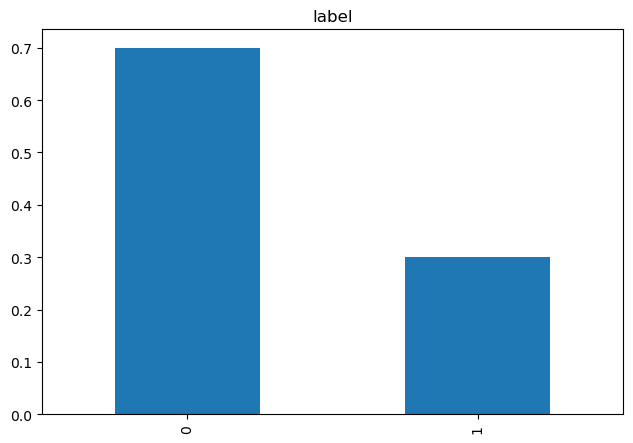

In [ ]:
# We will look at the count of loans approved and rejected in the train datasets
new_df['label'].value_counts(normalize=True).plot.bar(figsize=(7.5,5),
                                                     title='label')
# 70% were bad and 30% were good

##### Insight
- 70% of the target variable was labeled bad and 30% labeled good. The disparity could influence ML algorithm

##### Independent Variable (Nominal)

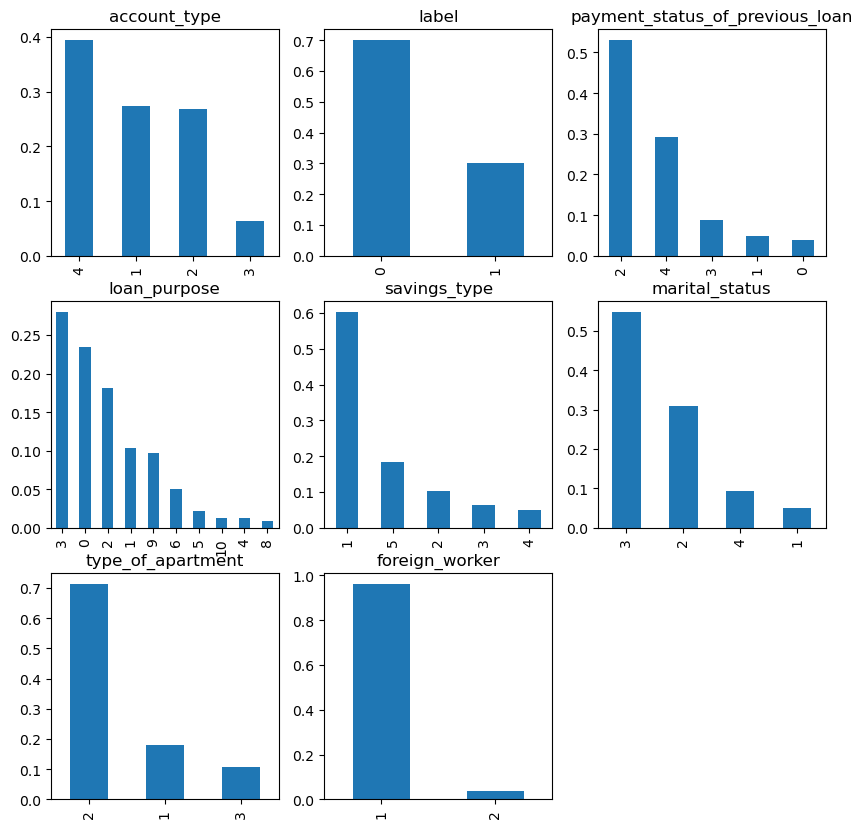

In [ ]:
lists = ['account_type','label','payment_status_of_previous_loan','loan_purpose',
         'savings_type','marital_status','type_of_apartment','foreign_worker']
plt.figure(1)
for i in range(len(lists)):
    plt.subplot(3,3,i+1)
    new_df[lists[i]].value_counts(normalize=True).plot.bar(figsize=(10,10),title=lists[i])

plt.savefig('eda_for_independent_categories')
plt.show()

##### Insights
- The plots above reveals percentage of each groups in each nominal variable. For foreign worker, customers labeled with "1" were over 98% while customers labeled "2" were just 2%. Similar interpretation can be applied to other plots

##### Independent variables (ordinal)

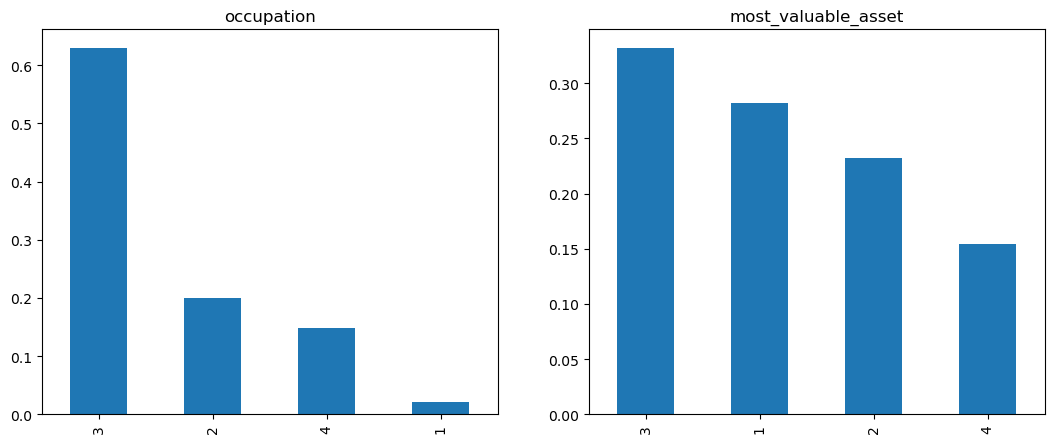

In [ ]:
ordinal = ['occupation','most_valuable_asset']
plt.figure(1)
for i in range(len(ordinal)):
    plt.subplot(1,3,i+1)
    new_df[ordinal[i]].value_counts(normalize=True).plot.bar(figsize=(20,5),title=ordinal[i])

plt.show()

##### Insights
- Over 65% of the customers had an occupation labeled as "3", 20% of the customers had occupation labeled as "2", 16% of customers had occupation labeled as "4" and 4% of customers has occupation labeled as "1"

##### Independent variable (Numerical)

- We will use distribution plot to see if the credit_amount, credit_duration and age normally distributed and use box plots to check for outliers

<Axes: xlabel='credit_amount', ylabel='Count'>

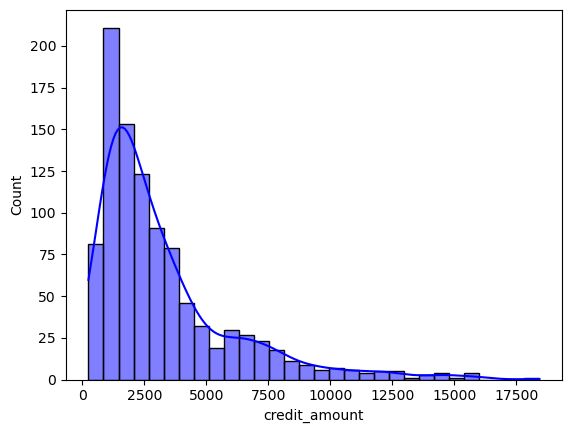

In [ ]:
sns.histplot(data=new_df,x='credit_amount',bins=30,kde=True,color='b')

##### Insights
- Credit amount isn't normally distributed because it's left skewed

##### 3.5.2 Bivariate Analysis

##### Nominal variable vs target variable

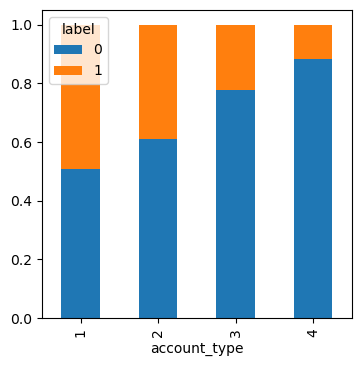

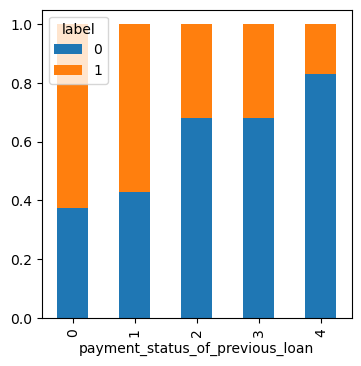

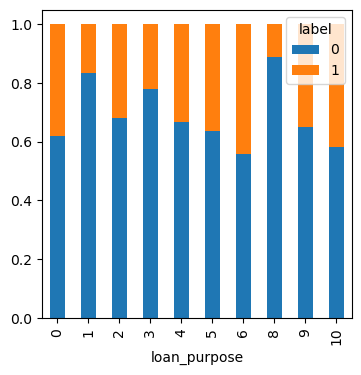

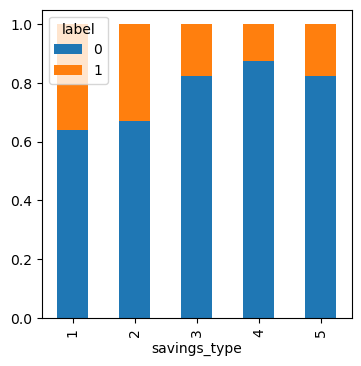

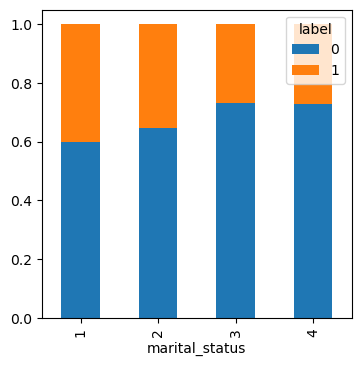

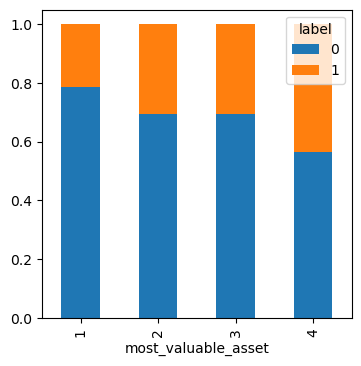

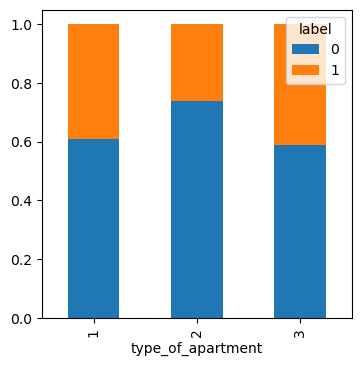

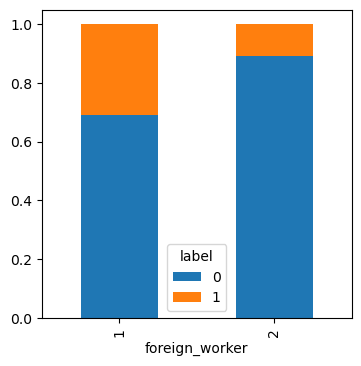

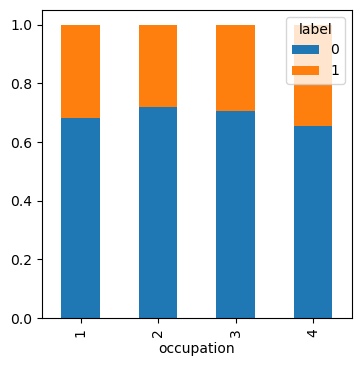

In [ ]:
nominal_columns = ['account_type','payment_status_of_previous_loan','loan_purpose','savings_type',
          'marital_status','most_valuable_asset','type_of_apartment','foreign_worker','occupation']
for col in range(len(nominal_columns)):
    new = pd.crosstab(new_df[nominal_columns[col]],new_df['label'])
    new.div(new.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(4,4))
plt.show()

Insights
- account type "4" had 10% approval (the worst), while account type "1" had 50% approval (the best)
- payment status of previous loan of "4" had 18% approval (the worst), payment status of previous loan of "0" had 62% (the best)
- Similar interpretation techniques can be applied to other plots

##### Numerical Independent Variable vs Target Variable

<Axes: title={'center': 'label vs credit amount'}, xlabel='label'>

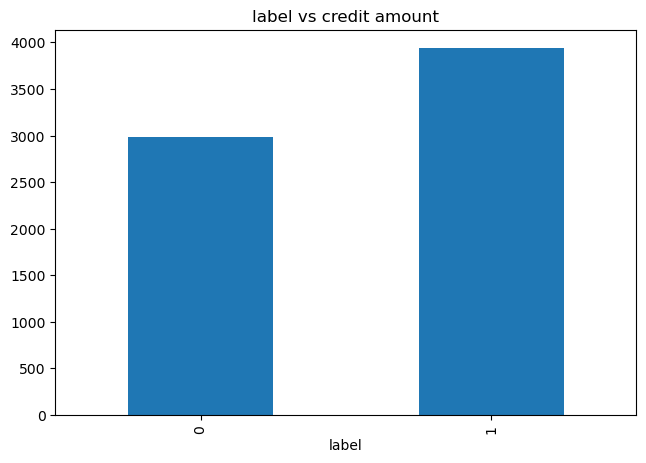

In [ ]:
# We will obtain mean of income of people that got loan vs those that didn't get
new_df.groupby('label')['credit_amount'].mean().plot.bar(figsize=(7.5,5),
                                                         title='label vs credit amount')

##### Insights
- Approval rate had higher average credit amount i.e., higher credit amount were approved than lower amount

Text(0, 0.5, 'Percentage')

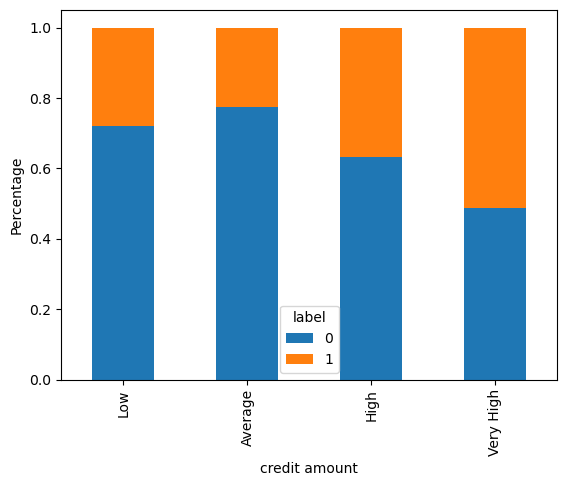

In [ ]:
bins = [0,2000,3800,7500,19000]
groups = ['Low','Average','High','Very High']
new_df['Income_bin'] = pd.cut(new_df['credit_amount'],bins,labels=groups)
Income_bin = pd.crosstab(new_df['Income_bin'],new_df['label'])
Income_bin.div(Income_bin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('credit amount')
plt.ylabel('Percentage')

In [ ]:
# new_df.groupby('Income_bin')['Income_bin'].count()

##### Insights
- Loan applications with very high credit amounts (>=7500) saw 50% approval while average credit amounts (2000 <= X <= 38000) saw 21% approval.

- Note: This negate our earlier hypothesis that proposes that lower credit amounts should get higher approvals


##### Multivariate analysis

In [ ]:
# Correction plots
matrix = new_df.corr()
matrix

,label,credit_duration(month),credit_amount,duration_of_current_employment,installment_percent,guarantors,duration_in_current_address,age,concurrent_credits,no_of_credits_at_the_bank,no_of_dependents
label,1.000000,0.214927,0.154740,-0.116002,0.072404,-0.025137,0.002967,-0.091272,-0.109844,-0.045732,-0.003015
credit_duration(month),0.214927,1.000000,0.624988,0.057381,0.074749,-0.024490,0.034067,-0.037550,-0.062884,-0.011284,-0.023834
credit_amount,0.154740,0.624988,1.000000,-0.008376,-0.271322,-0.027831,0.028917,0.032273,-0.069392,0.020785,0.017144
duration_of_current_employment,-0.116002,0.057381,-0.008376,1.000000,0.126161,-0.008116,0.245081,0.259116,-0.007279,0.125791,0.097192
installment_percent,0.072404,0.074749,-0.271322,0.126161,1.000000,-0.011398,0.049302,0.057271,0.007894,0.021669,-0.071207
guarantors,-0.025137,-0.024490,-0.027831,-0.008116,-0.011398,1.000000,-0.025678,-0.029826,-0.038235,-0.025447,0.020400
duration_in_current_address,0.002967,0.034067,0.028917,0.245081,0.049302,-0.025678,1.000000,0.265626,0.022654,0.089625,0.042643
age,-0.091272,-0.037550,0.032273,0.259116,0.057271,-0.029826,0.265626,1.000000,-0.030472,0.150718,0.118589
concurrent_credits,-0.109844,-0.062884,-0.069392,-0.007279,0.007894,-0.038235,0.022654,-0.030472,1.000000,-0.055810,-0.076891
no_of_credits_at_the_bank,-0.045732,-0.011284,0.020785,0.125791,0.021669,-0.025447,0.089625,0.150718,-0.055810,1.000000,0.109667


<Axes: >

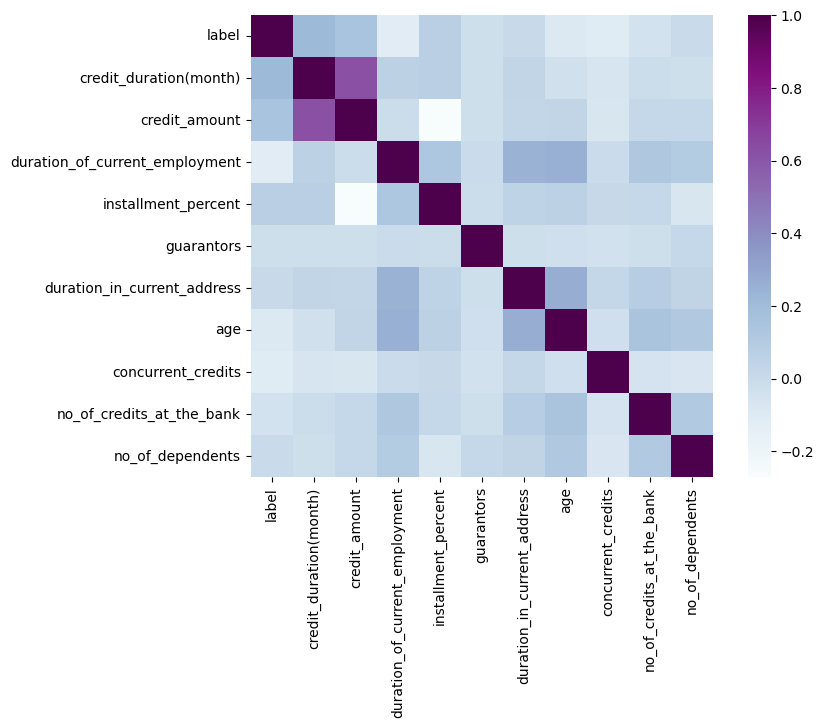

In [ ]:
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=1.0,square=True,cmap="BuPu")

Insights
- We see that the most correlated variables with label (target variable) are credit_duration(month), credit_amount, duration_of_current_employment and concurrent credits. Additionally, credit duration and credit amount are negatively correlated with label while duration of current employment and concurrent credits are positively correlated


### 4.0 Data Preprocessing, Feature Engineering Model benchmarking and Evaluation

#### 4.1 Pipeline for preprocessing and model building

##### 4.1.1 Splitting dataset into features and label


In [54]:
label = 'label'
features = list(new_df.drop(label,axis=1).columns)
X_full,y_full = new_df[features].values, new_df[label].values

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_full = np.expand_dims(y_full, axis=1)

print(f"the shape of the inputs X_full is: {X_full.shape}")
print(f"the shape of the targets y_full is: {y_full.shape}")

the shape of the inputs X_full is: (1000, 19)
the shape of the targets y_full is: (1000, 1)


##### 4.1.2 Split and prepare the dataset

Next, you will generate the training, cross validation, and test sets. You will use the same 60/20/20 proportions as before. You will also scale the features as you did in the previous section.

In [55]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
X, x_test, y, y_test = train_test_split(X_full, y_full, test_size=0.20, random_state=1)

##### Model Pipeline

In [57]:
# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6,7,8,9]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define preprocessing for nominal features
nominal_features = [10,11,12,13,14,16,17]
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define preprocessing for ordinal features
ordinal_features = [15,18]
ordinal_transformer = Pipeline(steps=[
    ('labelencode', OrdinalEncoder())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord',ordinal_transformer, ordinal_features)
    ])

In [58]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                ('nom',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [10, 11, 12, 13, 14, 16, 17]),
                                ('ord',
                                 Pipeline(steps=[('labelencode',
                                                  OrdinalEncoder())]),
                                 [15, 18])])

In [68]:
# Define the number of splits (K)
n_splits = 5  # You can change this to the desired number of splits

# Initialize Stratified K-Fold
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Initialize a variable to keep track of fold number
fold = 0


dtr = DecisionTreeClassifier()
xgb = GradientBoostingClassifier(n_estimators=100,verbose=False)
rf = RandomForestClassifier(n_estimators=100,verbose=False)
svc = SVC(probability=True,verbose=False)
xgb = XGBClassifier(n_estimators=100,verbose=False)
cat = CatBoostClassifier(n_estimators=100,verbose=False)

model_metrics = {}
models = [dtr,xgb,rf,svc,xgb,cat]
for index in range(0,len(models)):
  scores = []
  # Select the model
  model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', models[index])
                      ])
  for train_index, test_index in sss.split(X, y):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_benchmarking(X_train,y_train,X_test,y_test)

    # Replace this section with your modeling code (e.g., training and evaluating a classifier)
    print(f"Fold {fold}:")
    print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    # Fit the model with X_train and y_train
    model_pipeline = model_pipeline.fit(X_train, (y_train))


    # Obtain predictions
    validation_predictions = model_pipeline.predict(X_test)

    # Obtain scores for tests
    test_y_scores = model_pipeline.predict_proba(X_test)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_y_scores[:,1])
    test_accuracy = accuracy_score(y_test,validation_predictions)
    test_precision = precision_score(y_test,validation_predictions)
    test_recall = recall_score(y_test,validation_predictions)
    test_f1_score = (2*test_precision*test_recall)/(test_precision+test_recall)
    scores.append(test_f1_score)
  model_mean_score = np.mean(np.array(scores))
  model_metrics[f'{index}_scores'] = model_mean_score

[09:41:30] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[09:41:32] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Fold 1:
Train data shape: (640, 19), Test data shape: (160, 19)
[09:41:33] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[09:41:33] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Fold 2:
Train data shape: (640, 19), Test data shape: (160, 19)
[09:41:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[09:41:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Fold 3:
Train data shape: (640, 19), Test data shape: (160, 19)
[09:41:35] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[09:41:35] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Fold 4:
Train data shape: (640, 19), Test data shape: (160, 19)
[09:41:36] WARNING: ../src/learner.cc:767: 
Parameters: { "verbo

{'0_scores': 0.5262569149710912,
 '1_scores': 0.5614419541934196,
 '2_scores': 0.4942347652347652,
 '3_scores': 0.45609033124711224,
 '4_scores': 0.5614419541934196,
 '5_scores': 0.5582790910379916}

In [69]:
model_metrics

{'0_scores': 0.5262569149710912,
 '1_scores': 0.5614419541934196,
 '2_scores': 0.4942347652347652,
 '3_scores': 0.45609033124711224,
 '4_scores': 0.5614419541934196,
 '5_scores': 0.5582790910379916}

##### Model Assessment and conclusion
- To assess the model, we first reiterate the problem statement; we're interested in building a classification algorithm that identifies potential defaulting customers seeking loans. We observe that "Gradient Boosting" and "XGBoost Classifier" have the best F1 scores capped at 0.5614419541934196 average score of cross-validation scores was estimated. These model will be further optimized with "Hyperparameter tuning" before the best model is selected for deployment.